In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error as mse

In [56]:
import warnings
warnings.filterwarnings(action='ignore')

### Датасет: https://www.kaggle.com/datasets/vivovinco/20222023-football-player-stats

2022-2023 Football Player Stats <br>
2022-2023 European Leagues Player Stats

In [57]:
data = pd.read_csv('/Users/vahmers/Downloads/2022-2023 Football Player Stats.csv', encoding = "ISO-8859-1", sep=';')

In [58]:
data

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,...,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost,AerWon%
0,1,Brenden Aaronson,USA,MFFW,Leeds United,Premier League,21,2000,7,7,...,0.47,1.25,1.09,0.0,0.0,0.0,5.78,0.47,2.66,15.0
1,2,Yunis Abdelhamid,MAR,DF,Reims,Ligue 1,35,1987,10,10,...,0.00,0.20,1.30,0.0,0.0,0.0,8.50,2.00,0.70,74.1
2,3,Himad Abdelli,FRA,MF,Angers,Ligue 1,22,1999,3,0,...,0.00,0.00,0.00,0.0,0.0,0.0,10.00,0.00,3.33,0.0
3,4,Salis Abdul Samed,GHA,MF,Lens,Ligue 1,22,2000,9,9,...,0.00,0.44,1.11,0.0,0.0,0.0,7.89,0.44,0.78,36.4
4,5,Laurent Abergel,FRA,MF,Lorient,Ligue 1,29,1993,9,9,...,0.00,0.11,2.41,0.0,0.0,0.0,6.67,0.57,0.34,62.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2234,2235,Nadir Zortea,ITA,DF,Atalanta,Serie A,23,1999,5,0,...,0.00,3.64,0.91,0.0,0.0,0.0,10.90,0.91,0.91,50.0
2235,2236,Kurt Zouma,FRA,DF,West Ham,Premier League,27,1994,8,8,...,0.00,0.00,0.38,0.0,0.0,0.0,7.38,3.38,0.38,90.0
2236,2237,Igor Zubeldia,ESP,DF,Real Sociedad,La Liga,25,1997,6,5,...,0.00,0.00,1.11,0.0,0.0,0.0,10.70,1.78,2.44,42.1
2237,2238,Martín Zubimendi,ESP,MF,Real Sociedad,La Liga,23,1999,7,7,...,0.14,0.29,2.00,0.0,0.0,0.0,9.71,3.29,0.71,82.1


## 1. Выбор подвыборок с переменными для дальнейшего анализа

#### Дискретные:
Age : Player's age <br>
MP : Matches played <br>

#### Непрерывные:
PasTotDist : Total distance, in yards, that completed passes have traveled in any direction <br>
Recov : Number of loose balls recovered <br>

In [59]:
data = data[['Age', 'MP', 'Recov', 'PasTotDist']]
data

,Age,MP,Recov,PasTotDist
0,21,7,5.78,320.9
1,35,10,8.50,597.7
2,22,3,10.00,1520.0
3,22,9,7.89,998.3
4,29,9,6.67,677.4
...,...,...,...,...
2234,23,5,10.90,355.5
2235,27,8,7.38,653.4
2236,25,6,10.70,1023.8
2237,23,7,9.71,870.6


## 2. Непараметрическая оценка плотности распределения в виде гистограммы и с использованием функции плотности ядра

In [60]:
def drop_outliers(array):
    array_without_outliers = []
    q25, q75 = np.percentile(array, [25, 75])
    dist = q75 - q25
    lower = q25 - dist * 1.5
    upper = q25 + dist * 1.5
    for element in array:
        if (element > lower) and (element < upper):
            array_without_outliers.append(element)
    return array_without_outliers

In [61]:
def drop_outliers_soft(array):
    array_without_outliers = []
    q25, q75 = np.percentile(array, [25, 75])
    dist = q75 - q25
    lower = q25 - dist * 3
    upper = q25 + dist * 3
    for element in array:
        if (element > lower) and (element < upper):
            array_without_outliers.append(element)
    return array_without_outliers

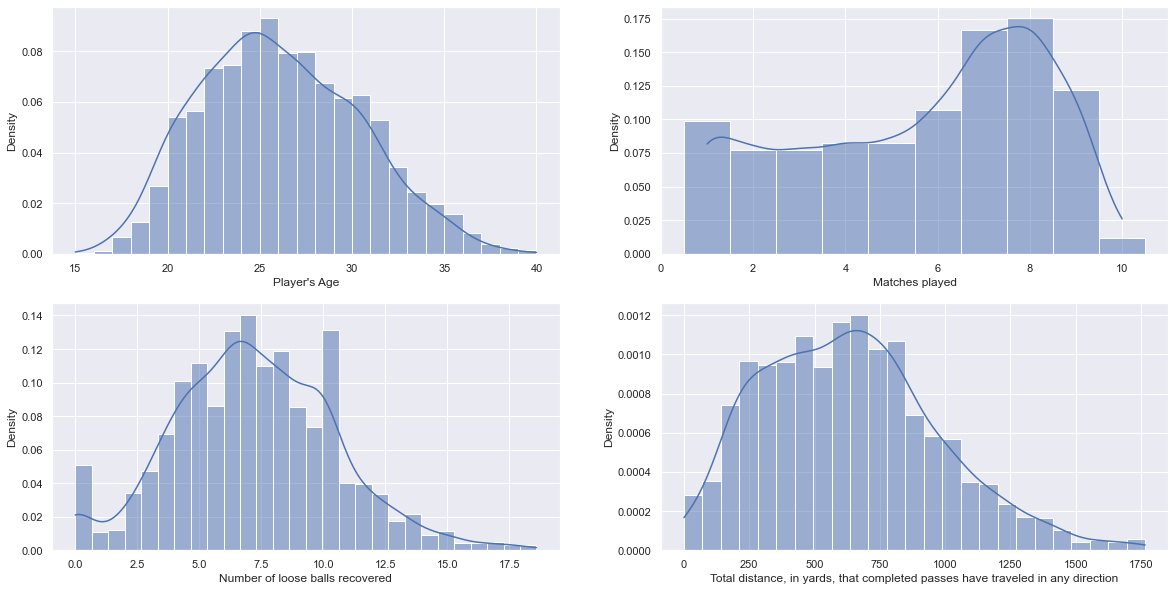

In [62]:
figure, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.set_theme()

age = sns.histplot(drop_outliers_soft(data.Age), ax=ax[0, 0], kde=True, stat='density',  bins=25)
age.set(xlabel="Player's Age")

mp = sns.histplot(drop_outliers_soft(data.MP), ax=ax[0, 1], kde=True, stat='density', discrete=True)
mp.set(xlabel='Matches played')

#shots = sns.histplot(drop_outliers_soft(data.Shots), ax=ax[1, 0], kde=True, stat='density')
#shots.set(xlabel='Shots total (Does not include penalty kicks)')

recov = sns.histplot(drop_outliers_soft(data.Recov), ax=ax[1, 0], kde=True, stat='density')
recov.set(xlabel='Number of loose balls recovered')

#aerwon = sns.histplot(drop_outliers_soft(data.AerWon), ax=ax[2,0], kde=True, stat='density')
#aerwon.set(xlabel='Aerials won')

pastotdist = sns.histplot(drop_outliers_soft(data.PasTotDist), ax=ax[1,1], kde=True, stat='density')
pastotdist.set(xlabel='Total distance, in yards, that completed passes have traveled in any direction')

#tklw = sns.histplot(drop_outliers_soft(data.TklW), ax=ax[3,0], kde=True, stat='density')
#tklw.set(xlabel="Tackles in which the tackler's team won possession of the ball")

plt.show()

## 3. Оценка порядковых статистик и представление их в виде “ящиков с усами”

In [63]:
def return_quantile(array):
    return np.array([
        np.quantile(array, 0.1),
        np.quantile(array, 0.25),
        np.quantile(array, 0.5),
        np.quantile(array, 0.75),
        np.quantile(array, 0.9),
    ])

def plot_box(array, label, discrt=False):
    figure, ax = plt.subplots(2, 1, figsize=(10, 10))
    
    histplot = sns.histplot(array, ax=ax[0], kde=False, stat='density', discrete=discrt)
    boxplot = sns.boxplot(array, ax=ax[1], linewidth=0.5) 
    
    histplot.set(xlabel=label)
    boxplot.set(xlabel=label)
    
    quantiles = return_quantile(array)
    for quantile in quantiles:
        ax[0].axvline(quantile, color='black', linestyle='--', alpha=0.75)
        ax[1].axvline(quantile, color='black', linestyle='--', alpha=0.75)
        
    plt.show()
    

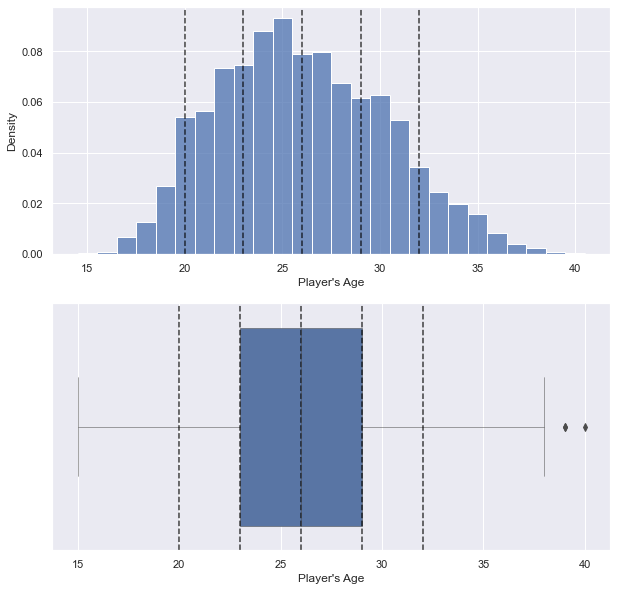

In [64]:
plot_box(drop_outliers_soft(data.Age), "Player's Age", discrt=True)

In [65]:
pd.Series(drop_outliers_soft(data.Age)).describe()

count    2237.000000
mean       26.005364
std         4.301471
min        15.000000
25%        23.000000
50%        26.000000
75%        29.000000
max        40.000000
dtype: float64

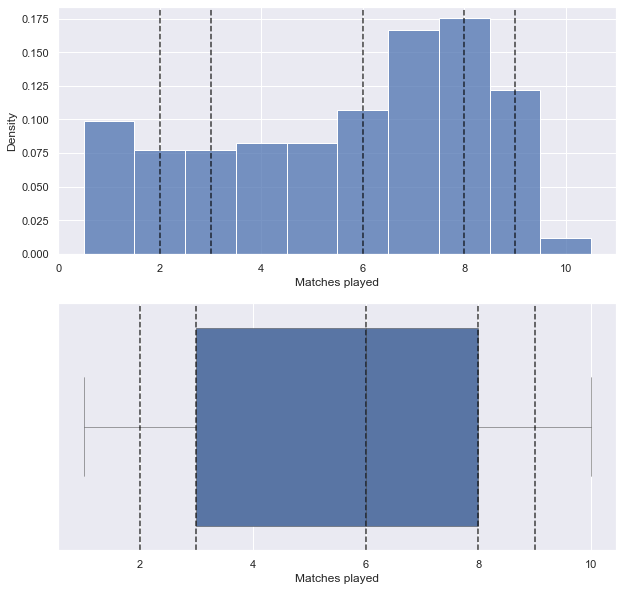

In [66]:
plot_box(drop_outliers_soft(data.MP), "Matches played", discrt=True)

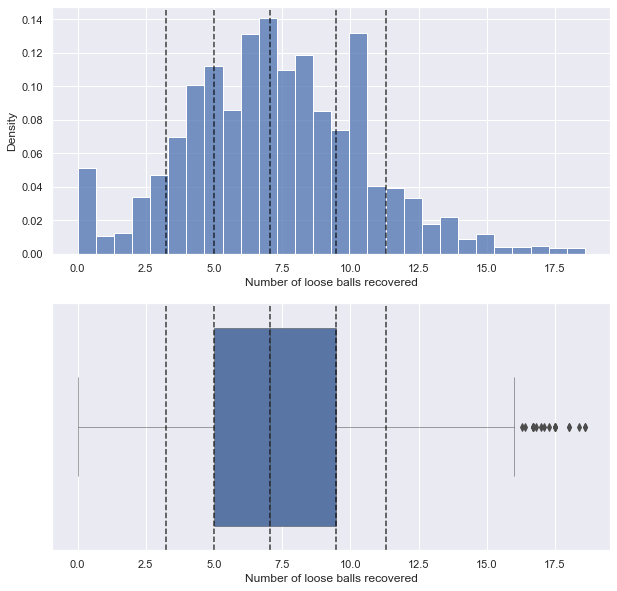

In [67]:
plot_box(drop_outliers_soft(data.Recov), "Number of loose balls recovered")

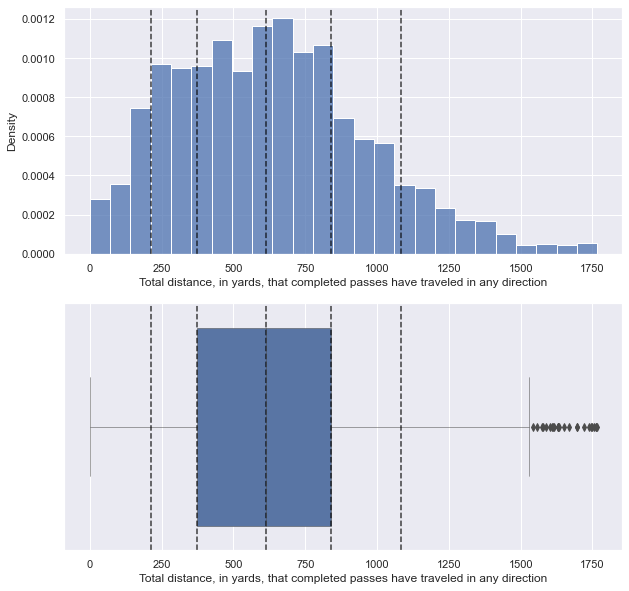

In [68]:
plot_box(drop_outliers_soft(data.PasTotDist), "Total distance, in yards, that completed passes have traveled in any direction")

## 4. Поиск теоретических распределений, которые могли бы описать выборку на основе результатов непараметрического анализа

In [69]:
def show_popular_distributions(array, label):
    figure, ax = plt.subplots(1, 1, figsize=(10,5))
    
    subplot = sns.histplot(array, kde=False, stat='density')
    subplot.set(xlabel=label)
    
    for distribution in (scipy.stats.norm, scipy.stats.alpha, scipy.stats.gamma,
                        scipy.stats.beta):#, scipy.stats.laplace):
        
        x_plot = np.linspace(np.min(array), np.max(array), 100)
        args = distribution.fit(array)
        print('Distribution', type(distribution).__name__, 'arguments:', args)
        y_plot = distribution.pdf(x_plot, *args)
        
        sns.lineplot(x_plot, y_plot, label=type(distribution).__name__)
        plt.legend()

Distribution norm_gen arguments: (26.005364327223962, 4.300509665508861)
Distribution alpha_gen arguments: (15.171145085097695, -38.661895798246235, 976.6034096090355)
Distribution gamma_gen arguments: (19.578614866409424, 6.853821958229463, 0.9781868442885429)
Distribution beta_gen arguments: (4.074885105596135, 6.538675818580643, 14.483397598026448, 30.02104079887795)


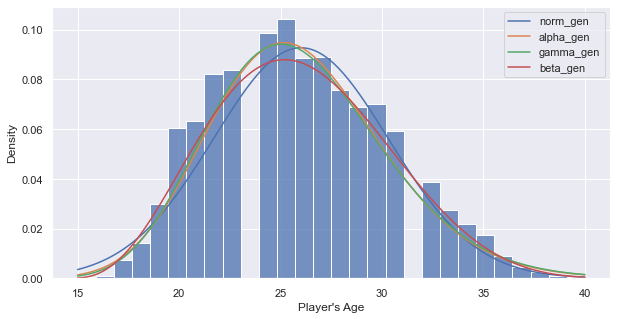

In [70]:
show_popular_distributions(drop_outliers_soft(data.Age), "Player's Age")

Distribution norm_gen arguments: (633.741393258427, 339.5911563793918)
Distribution alpha_gen arguments: (9.377985160089434, -2466.008477343055, 28732.40111414447)
Distribution gamma_gen arguments: (7.345944764163969, -300.45653452566216, 127.17192412504374)
Distribution beta_gen arguments: (2.756314718960283, 6.687497599948887, -74.25322232785126, 2424.984381180896)


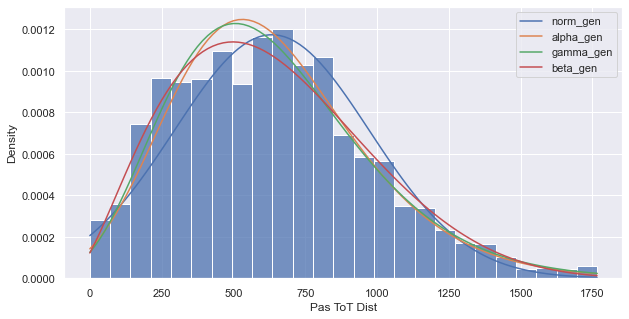

In [71]:
show_popular_distributions(drop_outliers_soft(data.PasTotDist), "Pas ToT Dist")

Distribution norm_gen arguments: (7.205764705882354, 3.293731778789756)
Distribution alpha_gen arguments: (8.494708695342034, -21.623188988125847, 240.12383657889836)
Distribution gamma_gen arguments: (117.12450172573844, -28.431234378037267, 0.3042659613773191)
Distribution beta_gen arguments: (116.91598073051503, 49649993.01217744, -28.39489197809226, 15117871.71463483)


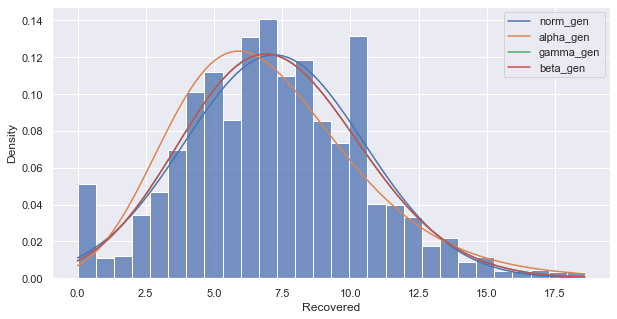

In [72]:
show_popular_distributions(drop_outliers_soft(data.Recov), "Recovered")

## 5. Оценка параметров распределений при помощи метода максимального правдоподобия и метода наименьших квадратов

In [73]:
from scipy.optimize import least_squares
def lse(array, distribution):
    
    x0 = distribution.fit(array)
    
    def func(x):
        list_quant = np.arange(0,1,0.05)
        xdata = np.quantile(array, list_quant)[1:]
    
        diff = (abs((distribution.ppf(list_quant, *x)[1:]) - xdata)**2).sum()
        return diff
    
    res = least_squares(func, x0)
    return res.x

In [74]:
age = drop_outliers_soft(data.Age)
distribution = scipy.stats.beta
mle_age = distribution.fit(age)

lse_age = lse(age, distribution)

print("Player's Age;", "Distribution:", type(distribution).__name__)
print("Maximal likelyhood ", mle_age)
print("Least squares ", lse_age)

Player's Age; Distribution: beta_gen
Maximal likelyhood  (4.074885105596135, 6.538675818580643, 14.483397598026448, 30.02104079887795)
Least squares  [ 3.55434902  6.23590958 15.04104267 30.34964634]


In [75]:
pastotdist = drop_outliers_soft(data.PasTotDist)
distribution = scipy.stats.beta
mle_pastotdist = distribution.fit(pastotdist)

lse_pastotdist = lse(pastotdist, distribution)

print("PasTotDist;", "Distribution:", type(distribution).__name__)
print("Maximal likelyhood ", mle_pastotdist)
print("Least squares ", lse_pastotdist)

PasTotDist; Distribution: beta_gen
Maximal likelyhood  (2.756314718960283, 6.687497599948887, -74.25322232785126, 2424.984381180896)
Least squares  [   2.8590259     6.93962988  -74.25638659 2424.98260855]


In [76]:
recov = drop_outliers_soft(data.Recov)
distribution = scipy.stats.beta
mle_recov = distribution.fit(recov)

lse_recov = lse(recov, distribution)

print("Recov; ", "Distribution:", type(distribution).__name__)
print("Maximal likelyhood ", mle_recov)
print("Least squares ", lse_recov)

Recov;  Distribution: beta_gen
Maximal likelyhood  (116.91598073051503, 49649993.01217744, -28.39489197809226, 15117871.71463483)
Least squares  [ 1.16915981e+02  4.96499930e+07 -2.83948920e+01  1.51178717e+07]


## 6. Проверка оцененных параметров с помощью графика квантиль-квантиль (QQ).

In [77]:
def show_biplot(array, distribution):
    figure, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    args = distribution.fit(array)
    print('Distribution', type(distribution).__name__, 'arguments:', args)
    scipy.stats.probplot(array, dist=distribution, sparams=(args), plot=ax)
    
    ax.get_lines()[0].set_marker('o')
    
    ax.get_lines()[1].set_ls('--')
    ax.get_lines()[1].set_color('black')
    ax.get_lines()[1].set_linewidth(0.75)
    
    plt.show()

Distribution beta_gen arguments: (4.074885105596135, 6.538675818580643, 14.483397598026448, 30.02104079887795)


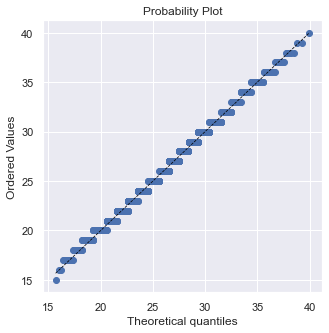

In [78]:
show_biplot(drop_outliers_soft(data.Age), distribution=scipy.stats.beta)

Distribution beta_gen arguments: (2.756314718960283, 6.687497599948887, -74.25322232785126, 2424.984381180896)


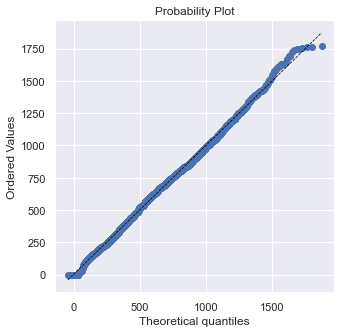

In [79]:
show_biplot(drop_outliers_soft(data.PasTotDist), distribution=scipy.stats.beta)

Distribution beta_gen arguments: (116.91598073051503, 49649993.01217744, -28.39489197809226, 15117871.71463483)


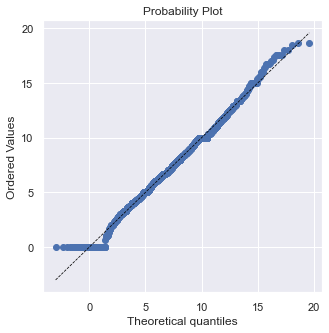

In [80]:
show_biplot(drop_outliers_soft(data.Recov), distribution=scipy.stats.beta)

## 7. Оценка достоверности подогнанных распределений при помощи статистических тестов

In [81]:
def test_distribution(array, distribution, cdf):
    args = distribution.fit(array)
    
    kstest = scipy.stats.kstest(array, cdf=cdf, args=args).pvalue
    cramervonmises = scipy.stats.cramervonmises(array, cdf=cdf, args=args).pvalue
    
    print('Kolmogorov-Smirnov Test: {:.5f}'.format(kstest))
    print('Cramer–Von Mises Test: {:.5f}'.format(cramervonmises))

In [82]:
test_distribution(drop_outliers_soft(data.Age[::1]), distribution=scipy.stats.beta, cdf='beta')

Kolmogorov-Smirnov Test: 0.00000
Cramer–Von Mises Test: 0.00321


In [83]:
test_distribution(drop_outliers_soft(data.PasTotDist[::1]), distribution=scipy.stats.beta, cdf='beta')

Kolmogorov-Smirnov Test: 0.09149
Cramer–Von Mises Test: 0.20509


In [84]:
test_distribution(drop_outliers_soft(data.Recov[::1]), distribution=scipy.stats.beta, cdf='beta')

Kolmogorov-Smirnov Test: 0.00720
Cramer–Von Mises Test: 0.25854


## 8. Сэмплирование СВ: inverse transform sampling и scipy.stats.rv_continuous.rvs 

In [85]:
def inverse_transform_sampling(array, distribution):
    args = distribution.fit(array)
    print('Distribution', type(distribution).__name__, 'arguments:', args)
    data = np.random.uniform(size=len(array))
    sample = distribution(*args)
    sample= sample.ppf(data)
    return sample

def rvs_sampling(array, distribution):
    args = distribution.fit(array)
    sample = distribution.rvs(*args, size=len(array))
    return sample

def return_cdf(array):
    bins, x = np.histogram(array, bins=100)
    probas = bins / sum(bins)
    y = np.cumsum(probas)
    return x[:100], y[:100]

Player's Age
Distribution beta_gen arguments: (4.074885105596135, 6.538675818580643, 14.483397598026448, 30.02104079887795)
Pas Tot Dist
Distribution beta_gen arguments: (2.756314718960283, 6.687497599948887, -74.25322232785126, 2424.984381180896)
Recov
Distribution beta_gen arguments: (116.91598073051503, 49649993.01217744, -28.39489197809226, 15117871.71463483)


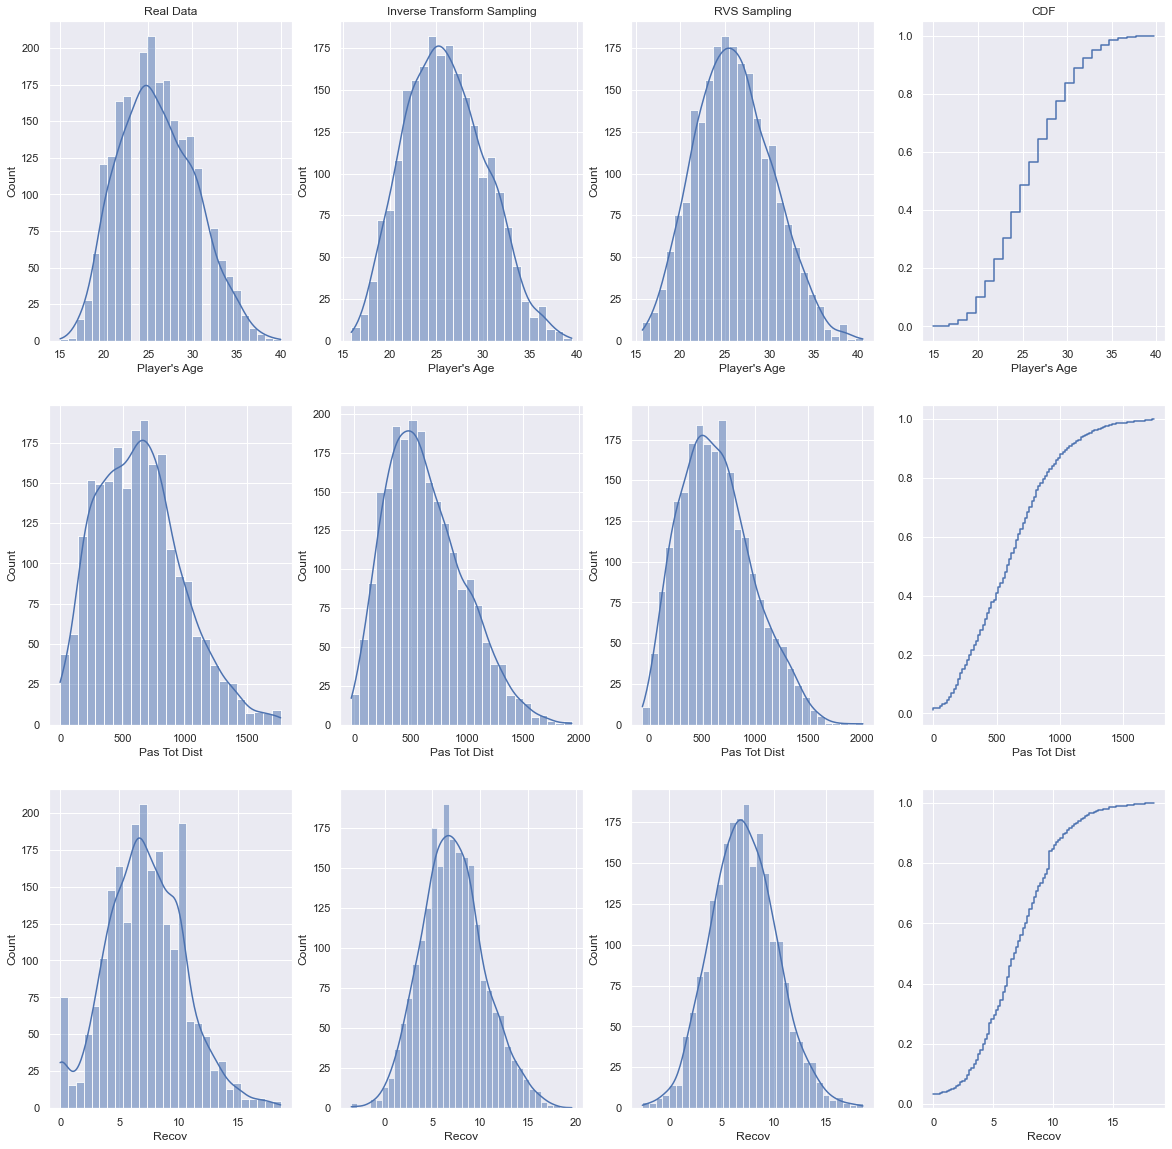

In [86]:
figure, ax = plt.subplots(3, 4, figsize=(20, 20))

print("Player's Age")
sns.histplot(drop_outliers_soft(data.Age), ax=ax[0, 0], kde=True)
sns.histplot(inverse_transform_sampling(drop_outliers_soft(data.Age), distribution=scipy.stats.beta), ax=ax[0, 1], kde=True)
sns.histplot(rvs_sampling(drop_outliers_soft(data.Age), distribution=scipy.stats.beta), ax=ax[0, 2], kde=True)
sns.lineplot(return_cdf(drop_outliers_soft(data.Age))[0], return_cdf(drop_outliers_soft(data.Age))[1], ax=ax[0, 3], drawstyle='steps-pre')

print('Pas Tot Dist')
sns.histplot(drop_outliers_soft(data.PasTotDist), ax=ax[1, 0], kde=True)
sns.histplot(inverse_transform_sampling(drop_outliers_soft(data.PasTotDist), distribution=scipy.stats.beta), ax=ax[1, 1], kde=True)
sns.histplot(rvs_sampling(drop_outliers_soft(data.PasTotDist), distribution=scipy.stats.beta), ax=ax[1, 2], kde=True)
sns.lineplot(return_cdf(drop_outliers_soft(data.PasTotDist))[0], return_cdf(drop_outliers_soft(data.PasTotDist))[1], ax=ax[1, 3], drawstyle='steps-pre')

print('Recov')
sns.histplot(drop_outliers_soft(data.Recov), ax=ax[2, 0], kde=True)
sns.histplot(inverse_transform_sampling(drop_outliers_soft(data.Recov), distribution=scipy.stats.beta), ax=ax[2, 1], kde=True)
sns.histplot(rvs_sampling(drop_outliers_soft(data.Recov), distribution=scipy.stats.beta), ax=ax[2, 2], kde=True)
sns.lineplot(return_cdf(drop_outliers_soft(data.Recov))[0], return_cdf(drop_outliers_soft(data.Recov))[1], ax=ax[2, 3], drawstyle='steps-pre')

ax[0, 0].set_title('Real Data')
ax[0, 1].set_title('Inverse Transform Sampling')
ax[0, 2].set_title('RVS Sampling')
ax[0, 3].set_title('CDF')

ax[0, 0].set(xlabel="Player's Age")
ax[0, 1].set(xlabel="Player's Age")
ax[0, 2].set(xlabel="Player's Age")
ax[0, 3].set(xlabel="Player's Age")
ax[1, 0].set(xlabel='Pas Tot Dist')
ax[1, 1].set(xlabel='Pas Tot Dist')
ax[1, 2].set(xlabel='Pas Tot Dist')
ax[1, 3].set(xlabel='Pas Tot Dist')
ax[2, 0].set(xlabel='Recov')
ax[2, 1].set(xlabel='Recov')
ax[2, 2].set(xlabel='Recov')
ax[2, 3].set(xlabel='Recov')

plt.show()